In [3]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler
from src.stat_tests import AR1, ADF, BP, SW

import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [11]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
tcu = pd.read_csv('./data/fred/TCU.csv', low_memory=False, encoding='utf-8')
fedrate = pd.read_csv('./data/fred/DFF.csv', low_memory=False, encoding='utf-8')

set = [rgdp, tcu, fedrate]
for df in set:
    df.set_index("observation_date", inplace=True)


In [12]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp, tcu.loc[rgdp.index], fedrate.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
target = target.loc[X.index]

X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)

(np.True_, True)

In [13]:
# House Price Data Prep
# yn_map = {"yes": 1, "no": 0}
y = target.values

# Map binaries to 0/1
# X.mainroad = X.mainroad.map(yn_map)
# X.guestroom = X.guestroom.map(yn_map)
# X.basement = X.basement.map(yn_map)
# X.hotwaterheating = X.hotwaterheating.map(yn_map)
# X.airconditioning = X.airconditioning.map(yn_map)
# X.prefarea = X.prefarea.map(yn_map)

# # Get One-Hot for categoricals
# furnish_dummies = pd.get_dummies(X.furnishingstatus, drop_first=True).astype(int)
# X = X.drop(columns=["furnishingstatus"])
# X = pd.concat([X, furnish_dummies], axis=1)

# # Remove colnames for symbolic brevity
# X = s.fit_transform(X) # Uncomment to normalize the dataset
X = X.values

In [14]:
X_test = X[-1]
y_yest = y[-1]

X_fit = X[:-1, :]
y_fit = y[:-1]

ols = OLS(X_fit, y_fit)
fit = ols.fit(diagnosis_trend="n")
y_fit

array([10083.855, 10090.569,  9998.704,  9951.916, 10029.51 , 10080.195,
       10115.329, 10236.435, 10347.429, 10449.673, 10558.648, 10576.275,
       10637.847, 10688.606, 10833.987, 10939.116, 11087.361, 11152.176,
       11279.932, 11319.951, 11353.721, 11450.31 , 11528.067, 11614.418,
       11808.14 , 11914.063, 12037.775, 12115.472, 12317.221, 12471.01 ,
       12577.495, 12703.742, 12821.339, 12982.752, 13191.67 , 13315.597,
       13426.748, 13604.771, 13827.98 , 13878.147, 14130.908, 14145.312,
       14229.765, 14183.12 , 14271.694, 14214.516, 14253.574, 14372.785,
       14460.848, 14519.633, 14537.58 , 14614.141, 14743.567, 14988.782,
       15162.76 , 15248.68 , 15366.85 , 15512.619, 15670.88 , 15844.727,
       15922.782, 16047.587, 16136.734, 16353.835, 16396.151, 16420.738,
       16561.866, 16611.69 , 16713.314, 16809.587, 16915.191, 16843.003,
       16943.291, 16854.295, 16485.35 , 16298.262, 16269.145, 16326.281,
       16502.754, 16582.71 , 16743.162, 16872.266, 

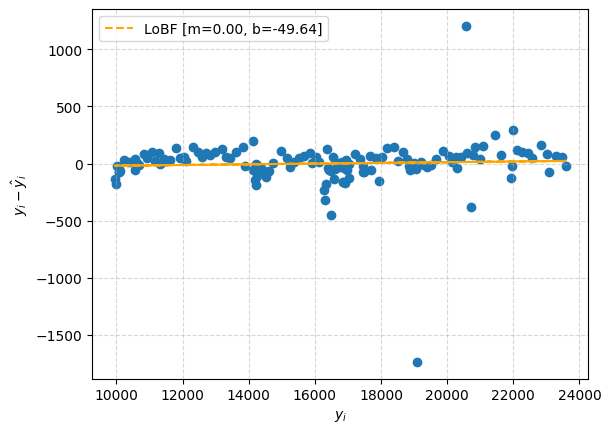

In [15]:
n = len(fit.resid)
m, b = np.polyfit(y_fit, fit.resid, 1)

line = m * y_fit + b


plt.scatter(y_fit, fit.resid)
plt.plot(y_fit, line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")

plt.xlabel(r"$y_i$")
plt.ylabel(r"$y_i - \hat{y}_i$")

plt.grid(alpha=0.5, linestyle="--")

plt.legend()
plt.show()

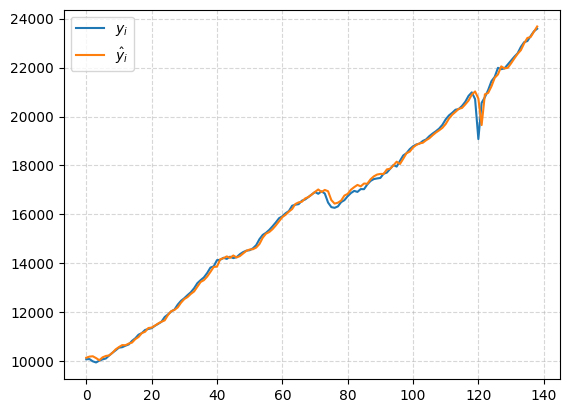

In [7]:
x = np.array([i for i in range(len(y_fit))])
plt.plot(x, y_fit, label=r"$y_i$")
plt.plot(x, fit.fitted_values, label=r"$\hat{y}_i$")

plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.show()

In [16]:
fit.resid_heteroske

reject: False
pval: 0.8908667877110521
test_stat: 6.051460783400594
stat_name: Breusch-Pagan Test (Chi^2 Statistic)

In [17]:
print(ols.predict(X_test))
fit.resid_normality

23723.63199439096


reject: True
pval: 1.1237243715635138e-18
test_stat: 0.5591360967721593
stat_name: Shapiro-Wilk Test (Approximated Z-Statistic)

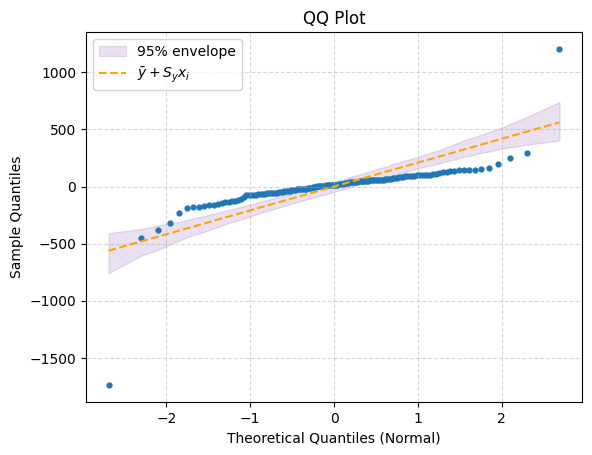

In [18]:
fit.qq(line="45")

In [19]:
fit

fitted_values: [10133.42027713 10167.16075859 10175.72528983 10091.72543992
 10054.00607598 10153.98405048 10183.27174426 10206.1204689
 10335.00392312 10433.64769629 10520.2487181  10629.14088768
 10635.25041863 10699.80345693 10754.17763171 10891.67226209
 10985.88380098 11130.17244957 11192.22029801 11323.15147001
 11348.74523511 11407.02636369 11509.88664533 11583.86535298
 11673.11057416 11862.16103756 11984.73880982 12093.9734972
 12174.60956025 12371.39675155 12523.20294214 12613.26348284
 12744.56288359 12877.73431118 13068.90248738 13259.62664086
 13377.54834104 13501.5173089  13681.98226943 13898.63614336
 13936.311132   14202.3198654  14231.76407481 14328.08113673
 14292.5721725  14404.93079574 14364.63195185 14413.93768444
 14526.49108217 14608.24820696 14655.30296394 14676.25869759
 14737.41265951 14875.05903409 15111.13465616 15278.3911813
 15352.67236406 15464.13888386 15604.53665024 15754.58397512
 15915.41775753 15994.60373657 16125.62874092 16228.94175721
 16432.55202